In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
generator_learning_rate = 0.001
discriminator_learning_rate = 0.001
num_epochs = 300
batch_size = 128
LATENT_DIM = 100
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x



##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='dataset', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='dataset', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [3]:
##########################
### MODEL
##########################

class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        
        
        self.generator = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, IMG_SIZE),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Linear(IMG_SIZE, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)


In [4]:
torch.manual_seed(random_seed)

model = GAN()
model = model.to(device)

optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

In [5]:
start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        
        
        features = (features - 0.5)*2.
        features = features.view(-1, IMG_SIZE).to(device) 
        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)
        

        ### FORWARD AND BACK PROP
        
        
        # --------------------------
        # Train Generator
        # --------------------------
        
        # Make new images
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)
        
        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features)
        
        gener_loss = F.binary_cross_entropy(discr_pred, valid)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()
        
        # --------------------------
        # Train Discriminator
        # --------------------------        
        
        discr_pred_real = model.discriminator_forward(features.view(-1, IMG_SIZE))
        real_loss = F.binary_cross_entropy(discr_pred_real, valid)
        
        discr_pred_fake = model.discriminator_forward(generated_features.detach())
        fake_loss = F.binary_cross_entropy(discr_pred_fake, fake)
        
        discr_loss = 0.5*(real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()        
        
        discr_costs.append(discr_loss)
        gener_costs.append(gener_loss)
        
        
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/300 | Batch 000/469 | Gen/Dis Loss: 0.6840/0.7187
Epoch: 001/300 | Batch 100/469 | Gen/Dis Loss: 4.5653/0.0418
Epoch: 001/300 | Batch 200/469 | Gen/Dis Loss: 1.8552/0.0949
Epoch: 001/300 | Batch 300/469 | Gen/Dis Loss: 1.3644/0.1683
Epoch: 001/300 | Batch 400/469 | Gen/Dis Loss: 2.5513/0.0578
Time elapsed: 0.13 min
Epoch: 002/300 | Batch 000/469 | Gen/Dis Loss: 2.1382/0.1542
Epoch: 002/300 | Batch 100/469 | Gen/Dis Loss: 1.8133/0.2276
Epoch: 002/300 | Batch 200/469 | Gen/Dis Loss: 1.0152/0.4610
Epoch: 002/300 | Batch 300/469 | Gen/Dis Loss: 1.2686/0.3756
Epoch: 002/300 | Batch 400/469 | Gen/Dis Loss: 1.0025/0.4430
Time elapsed: 0.27 min
Epoch: 003/300 | Batch 000/469 | Gen/Dis Loss: 0.8181/0.4899
Epoch: 003/300 | Batch 100/469 | Gen/Dis Loss: 1.0432/0.4441
Epoch: 003/300 | Batch 200/469 | Gen/Dis Loss: 1.4024/0.3968
Epoch: 003/300 | Batch 300/469 | Gen/Dis Loss: 0.9809/0.4754
Epoch: 003/300 | Batch 400/469 | Gen/Dis Loss: 0.7787/0.5225
Time elapsed: 0.40 min
Epoch: 004/300 |

Epoch: 026/300 | Batch 100/469 | Gen/Dis Loss: 0.9078/0.6281
Epoch: 026/300 | Batch 200/469 | Gen/Dis Loss: 1.3609/0.5987
Epoch: 026/300 | Batch 300/469 | Gen/Dis Loss: 0.9646/0.6049
Epoch: 026/300 | Batch 400/469 | Gen/Dis Loss: 0.9009/0.5804
Time elapsed: 3.36 min
Epoch: 027/300 | Batch 000/469 | Gen/Dis Loss: 1.0450/0.5681
Epoch: 027/300 | Batch 100/469 | Gen/Dis Loss: 1.1983/0.5289
Epoch: 027/300 | Batch 200/469 | Gen/Dis Loss: 1.0578/0.5572
Epoch: 027/300 | Batch 300/469 | Gen/Dis Loss: 1.1022/0.6419
Epoch: 027/300 | Batch 400/469 | Gen/Dis Loss: 1.0554/0.5829
Time elapsed: 3.49 min
Epoch: 028/300 | Batch 000/469 | Gen/Dis Loss: 0.9211/0.6206
Epoch: 028/300 | Batch 100/469 | Gen/Dis Loss: 1.0447/0.5816
Epoch: 028/300 | Batch 200/469 | Gen/Dis Loss: 1.3183/0.5704
Epoch: 028/300 | Batch 300/469 | Gen/Dis Loss: 0.9554/0.5868
Epoch: 028/300 | Batch 400/469 | Gen/Dis Loss: 0.9161/0.6130
Time elapsed: 3.63 min
Epoch: 029/300 | Batch 000/469 | Gen/Dis Loss: 1.1473/0.5556
Epoch: 029/300 |

Epoch: 051/300 | Batch 100/469 | Gen/Dis Loss: 0.7628/0.6532
Epoch: 051/300 | Batch 200/469 | Gen/Dis Loss: 1.1530/0.6221
Epoch: 051/300 | Batch 300/469 | Gen/Dis Loss: 0.8051/0.6578
Epoch: 051/300 | Batch 400/469 | Gen/Dis Loss: 0.9365/0.6326
Time elapsed: 6.66 min
Epoch: 052/300 | Batch 000/469 | Gen/Dis Loss: 0.9350/0.6374
Epoch: 052/300 | Batch 100/469 | Gen/Dis Loss: 0.9052/0.6301
Epoch: 052/300 | Batch 200/469 | Gen/Dis Loss: 0.7209/0.6446
Epoch: 052/300 | Batch 300/469 | Gen/Dis Loss: 0.9530/0.6354
Epoch: 052/300 | Batch 400/469 | Gen/Dis Loss: 0.8816/0.6437
Time elapsed: 6.77 min
Epoch: 053/300 | Batch 000/469 | Gen/Dis Loss: 0.8662/0.6483
Epoch: 053/300 | Batch 100/469 | Gen/Dis Loss: 0.7949/0.6358
Epoch: 053/300 | Batch 200/469 | Gen/Dis Loss: 0.8807/0.6201
Epoch: 053/300 | Batch 300/469 | Gen/Dis Loss: 0.7721/0.6175
Epoch: 053/300 | Batch 400/469 | Gen/Dis Loss: 0.7601/0.6338
Time elapsed: 6.89 min
Epoch: 054/300 | Batch 000/469 | Gen/Dis Loss: 0.8734/0.6377
Epoch: 054/300 |

Epoch: 076/300 | Batch 100/469 | Gen/Dis Loss: 0.8588/0.6372
Epoch: 076/300 | Batch 200/469 | Gen/Dis Loss: 0.8672/0.6571
Epoch: 076/300 | Batch 300/469 | Gen/Dis Loss: 0.8817/0.6846
Epoch: 076/300 | Batch 400/469 | Gen/Dis Loss: 0.6816/0.6246
Time elapsed: 9.55 min
Epoch: 077/300 | Batch 000/469 | Gen/Dis Loss: 0.8497/0.5831
Epoch: 077/300 | Batch 100/469 | Gen/Dis Loss: 0.7977/0.6587
Epoch: 077/300 | Batch 200/469 | Gen/Dis Loss: 0.8163/0.6460
Epoch: 077/300 | Batch 300/469 | Gen/Dis Loss: 0.8524/0.6361
Epoch: 077/300 | Batch 400/469 | Gen/Dis Loss: 1.1062/0.5808
Time elapsed: 9.66 min
Epoch: 078/300 | Batch 000/469 | Gen/Dis Loss: 0.9336/0.6243
Epoch: 078/300 | Batch 100/469 | Gen/Dis Loss: 0.8905/0.6544
Epoch: 078/300 | Batch 200/469 | Gen/Dis Loss: 0.8291/0.6373
Epoch: 078/300 | Batch 300/469 | Gen/Dis Loss: 0.7767/0.6601
Epoch: 078/300 | Batch 400/469 | Gen/Dis Loss: 1.0960/0.6439
Time elapsed: 9.78 min
Epoch: 079/300 | Batch 000/469 | Gen/Dis Loss: 0.8556/0.6222
Epoch: 079/300 |

Epoch: 101/300 | Batch 100/469 | Gen/Dis Loss: 0.9407/0.6395
Epoch: 101/300 | Batch 200/469 | Gen/Dis Loss: 0.8431/0.6325
Epoch: 101/300 | Batch 300/469 | Gen/Dis Loss: 0.8571/0.6200
Epoch: 101/300 | Batch 400/469 | Gen/Dis Loss: 0.9851/0.6352
Time elapsed: 12.43 min
Epoch: 102/300 | Batch 000/469 | Gen/Dis Loss: 0.8091/0.6437
Epoch: 102/300 | Batch 100/469 | Gen/Dis Loss: 0.8709/0.6380
Epoch: 102/300 | Batch 200/469 | Gen/Dis Loss: 0.8609/0.6326
Epoch: 102/300 | Batch 300/469 | Gen/Dis Loss: 0.7736/0.6400
Epoch: 102/300 | Batch 400/469 | Gen/Dis Loss: 0.7917/0.6651
Time elapsed: 12.55 min
Epoch: 103/300 | Batch 000/469 | Gen/Dis Loss: 0.9586/0.6475
Epoch: 103/300 | Batch 100/469 | Gen/Dis Loss: 0.8746/0.6357
Epoch: 103/300 | Batch 200/469 | Gen/Dis Loss: 0.9347/0.6401
Epoch: 103/300 | Batch 300/469 | Gen/Dis Loss: 0.8144/0.6287
Epoch: 103/300 | Batch 400/469 | Gen/Dis Loss: 0.9791/0.6192
Time elapsed: 12.66 min
Epoch: 104/300 | Batch 000/469 | Gen/Dis Loss: 0.7856/0.6576
Epoch: 104/30

Epoch: 126/300 | Batch 100/469 | Gen/Dis Loss: 0.8712/0.6175
Epoch: 126/300 | Batch 200/469 | Gen/Dis Loss: 0.8874/0.6399
Epoch: 126/300 | Batch 300/469 | Gen/Dis Loss: 0.8501/0.6859
Epoch: 126/300 | Batch 400/469 | Gen/Dis Loss: 1.0246/0.5879
Time elapsed: 15.68 min
Epoch: 127/300 | Batch 000/469 | Gen/Dis Loss: 0.8256/0.6212
Epoch: 127/300 | Batch 100/469 | Gen/Dis Loss: 0.8414/0.6497
Epoch: 127/300 | Batch 200/469 | Gen/Dis Loss: 0.8481/0.6525
Epoch: 127/300 | Batch 300/469 | Gen/Dis Loss: 0.8814/0.6423
Epoch: 127/300 | Batch 400/469 | Gen/Dis Loss: 0.8277/0.6227
Time elapsed: 15.81 min
Epoch: 128/300 | Batch 000/469 | Gen/Dis Loss: 0.8287/0.6362
Epoch: 128/300 | Batch 100/469 | Gen/Dis Loss: 0.8315/0.6384
Epoch: 128/300 | Batch 200/469 | Gen/Dis Loss: 0.8494/0.6582
Epoch: 128/300 | Batch 300/469 | Gen/Dis Loss: 0.9106/0.6392
Epoch: 128/300 | Batch 400/469 | Gen/Dis Loss: 1.0641/0.6212
Time elapsed: 15.95 min
Epoch: 129/300 | Batch 000/469 | Gen/Dis Loss: 0.8837/0.6147
Epoch: 129/30

Epoch: 151/300 | Batch 100/469 | Gen/Dis Loss: 0.9605/0.6079
Epoch: 151/300 | Batch 200/469 | Gen/Dis Loss: 0.7936/0.6158
Epoch: 151/300 | Batch 300/469 | Gen/Dis Loss: 0.8432/0.6241
Epoch: 151/300 | Batch 400/469 | Gen/Dis Loss: 0.8012/0.6289
Time elapsed: 19.00 min
Epoch: 152/300 | Batch 000/469 | Gen/Dis Loss: 0.9366/0.6017
Epoch: 152/300 | Batch 100/469 | Gen/Dis Loss: 0.8482/0.6720
Epoch: 152/300 | Batch 200/469 | Gen/Dis Loss: 0.8927/0.6300
Epoch: 152/300 | Batch 300/469 | Gen/Dis Loss: 0.9037/0.6451
Epoch: 152/300 | Batch 400/469 | Gen/Dis Loss: 0.8715/0.6507
Time elapsed: 19.13 min
Epoch: 153/300 | Batch 000/469 | Gen/Dis Loss: 0.9884/0.6461
Epoch: 153/300 | Batch 100/469 | Gen/Dis Loss: 1.0294/0.6255
Epoch: 153/300 | Batch 200/469 | Gen/Dis Loss: 0.8321/0.6306
Epoch: 153/300 | Batch 300/469 | Gen/Dis Loss: 0.8178/0.6492
Epoch: 153/300 | Batch 400/469 | Gen/Dis Loss: 0.8233/0.6467
Time elapsed: 19.27 min
Epoch: 154/300 | Batch 000/469 | Gen/Dis Loss: 0.8138/0.6799
Epoch: 154/30

Epoch: 176/300 | Batch 100/469 | Gen/Dis Loss: 0.8948/0.6147
Epoch: 176/300 | Batch 200/469 | Gen/Dis Loss: 0.8104/0.6136
Epoch: 176/300 | Batch 300/469 | Gen/Dis Loss: 0.8470/0.6430
Epoch: 176/300 | Batch 400/469 | Gen/Dis Loss: 0.8703/0.6301
Time elapsed: 22.32 min
Epoch: 177/300 | Batch 000/469 | Gen/Dis Loss: 0.8239/0.6551
Epoch: 177/300 | Batch 100/469 | Gen/Dis Loss: 1.0436/0.6239
Epoch: 177/300 | Batch 200/469 | Gen/Dis Loss: 1.0005/0.6531
Epoch: 177/300 | Batch 300/469 | Gen/Dis Loss: 0.8722/0.6202
Epoch: 177/300 | Batch 400/469 | Gen/Dis Loss: 0.8473/0.6428
Time elapsed: 22.46 min
Epoch: 178/300 | Batch 000/469 | Gen/Dis Loss: 0.8605/0.6634
Epoch: 178/300 | Batch 100/469 | Gen/Dis Loss: 0.8201/0.6338
Epoch: 178/300 | Batch 200/469 | Gen/Dis Loss: 1.0459/0.6352
Epoch: 178/300 | Batch 300/469 | Gen/Dis Loss: 0.7668/0.6324
Epoch: 178/300 | Batch 400/469 | Gen/Dis Loss: 0.9221/0.6288
Time elapsed: 22.59 min
Epoch: 179/300 | Batch 000/469 | Gen/Dis Loss: 0.8809/0.6190
Epoch: 179/30

Epoch: 201/300 | Batch 100/469 | Gen/Dis Loss: 0.9117/0.6078
Epoch: 201/300 | Batch 200/469 | Gen/Dis Loss: 0.9609/0.6506
Epoch: 201/300 | Batch 300/469 | Gen/Dis Loss: 1.1057/0.6604
Epoch: 201/300 | Batch 400/469 | Gen/Dis Loss: 1.0113/0.6282
Time elapsed: 25.41 min
Epoch: 202/300 | Batch 000/469 | Gen/Dis Loss: 0.8368/0.6252
Epoch: 202/300 | Batch 100/469 | Gen/Dis Loss: 1.0590/0.6201
Epoch: 202/300 | Batch 200/469 | Gen/Dis Loss: 0.8624/0.6430
Epoch: 202/300 | Batch 300/469 | Gen/Dis Loss: 0.9215/0.6102
Epoch: 202/300 | Batch 400/469 | Gen/Dis Loss: 0.8929/0.6301
Time elapsed: 25.52 min
Epoch: 203/300 | Batch 000/469 | Gen/Dis Loss: 0.9953/0.6272
Epoch: 203/300 | Batch 100/469 | Gen/Dis Loss: 0.8482/0.5933
Epoch: 203/300 | Batch 200/469 | Gen/Dis Loss: 0.8061/0.6506
Epoch: 203/300 | Batch 300/469 | Gen/Dis Loss: 0.9010/0.6155
Epoch: 203/300 | Batch 400/469 | Gen/Dis Loss: 0.8367/0.6242
Time elapsed: 25.64 min
Epoch: 204/300 | Batch 000/469 | Gen/Dis Loss: 0.8387/0.6739
Epoch: 204/30

Epoch: 226/300 | Batch 100/469 | Gen/Dis Loss: 0.8995/0.6172
Epoch: 226/300 | Batch 200/469 | Gen/Dis Loss: 0.9056/0.6295
Epoch: 226/300 | Batch 300/469 | Gen/Dis Loss: 0.8843/0.6402
Epoch: 226/300 | Batch 400/469 | Gen/Dis Loss: 0.9362/0.6098
Time elapsed: 28.30 min
Epoch: 227/300 | Batch 000/469 | Gen/Dis Loss: 0.8880/0.6133
Epoch: 227/300 | Batch 100/469 | Gen/Dis Loss: 0.9436/0.6064
Epoch: 227/300 | Batch 200/469 | Gen/Dis Loss: 0.9124/0.6121
Epoch: 227/300 | Batch 300/469 | Gen/Dis Loss: 0.8254/0.6350
Epoch: 227/300 | Batch 400/469 | Gen/Dis Loss: 1.1401/0.5958
Time elapsed: 28.42 min
Epoch: 228/300 | Batch 000/469 | Gen/Dis Loss: 0.8637/0.6451
Epoch: 228/300 | Batch 100/469 | Gen/Dis Loss: 0.9285/0.6180
Epoch: 228/300 | Batch 200/469 | Gen/Dis Loss: 0.9088/0.6093
Epoch: 228/300 | Batch 300/469 | Gen/Dis Loss: 0.9462/0.6187
Epoch: 228/300 | Batch 400/469 | Gen/Dis Loss: 0.9650/0.6041
Time elapsed: 28.53 min
Epoch: 229/300 | Batch 000/469 | Gen/Dis Loss: 0.9006/0.6252
Epoch: 229/30

Epoch: 251/300 | Batch 100/469 | Gen/Dis Loss: 0.8575/0.6266
Epoch: 251/300 | Batch 200/469 | Gen/Dis Loss: 0.8728/0.5918
Epoch: 251/300 | Batch 300/469 | Gen/Dis Loss: 0.8310/0.6803
Epoch: 251/300 | Batch 400/469 | Gen/Dis Loss: 0.8535/0.6451
Time elapsed: 31.18 min
Epoch: 252/300 | Batch 000/469 | Gen/Dis Loss: 1.0229/0.6138
Epoch: 252/300 | Batch 100/469 | Gen/Dis Loss: 0.9507/0.5779
Epoch: 252/300 | Batch 200/469 | Gen/Dis Loss: 0.9688/0.5793
Epoch: 252/300 | Batch 300/469 | Gen/Dis Loss: 0.8713/0.6222
Epoch: 252/300 | Batch 400/469 | Gen/Dis Loss: 0.8403/0.6544
Time elapsed: 31.30 min
Epoch: 253/300 | Batch 000/469 | Gen/Dis Loss: 0.8420/0.6280
Epoch: 253/300 | Batch 100/469 | Gen/Dis Loss: 0.9115/0.6182
Epoch: 253/300 | Batch 200/469 | Gen/Dis Loss: 0.9777/0.6188
Epoch: 253/300 | Batch 300/469 | Gen/Dis Loss: 1.0102/0.6422
Epoch: 253/300 | Batch 400/469 | Gen/Dis Loss: 1.0283/0.6067
Time elapsed: 31.42 min
Epoch: 254/300 | Batch 000/469 | Gen/Dis Loss: 0.8942/0.5995
Epoch: 254/30

Epoch: 276/300 | Batch 100/469 | Gen/Dis Loss: 0.9371/0.6346
Epoch: 276/300 | Batch 200/469 | Gen/Dis Loss: 0.9523/0.6189
Epoch: 276/300 | Batch 300/469 | Gen/Dis Loss: 1.0512/0.6292
Epoch: 276/300 | Batch 400/469 | Gen/Dis Loss: 0.9886/0.6374
Time elapsed: 34.07 min
Epoch: 277/300 | Batch 000/469 | Gen/Dis Loss: 0.9632/0.5875
Epoch: 277/300 | Batch 100/469 | Gen/Dis Loss: 1.0403/0.6247
Epoch: 277/300 | Batch 200/469 | Gen/Dis Loss: 0.8457/0.5866
Epoch: 277/300 | Batch 300/469 | Gen/Dis Loss: 0.9758/0.6060
Epoch: 277/300 | Batch 400/469 | Gen/Dis Loss: 0.8985/0.6163
Time elapsed: 34.19 min
Epoch: 278/300 | Batch 000/469 | Gen/Dis Loss: 1.0872/0.6336
Epoch: 278/300 | Batch 100/469 | Gen/Dis Loss: 1.0097/0.6066
Epoch: 278/300 | Batch 200/469 | Gen/Dis Loss: 1.0770/0.5608
Epoch: 278/300 | Batch 300/469 | Gen/Dis Loss: 0.9648/0.5967
Epoch: 278/300 | Batch 400/469 | Gen/Dis Loss: 0.9383/0.6125
Time elapsed: 34.31 min
Epoch: 279/300 | Batch 000/469 | Gen/Dis Loss: 0.8815/0.6084
Epoch: 279/30

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt


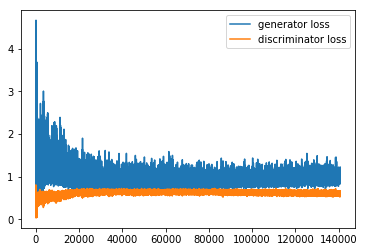

In [7]:
plt.plot(range(len(gener_costs)), gener_costs, label='generator loss')
plt.plot(range(len(discr_costs)), discr_costs, label='discriminator loss')
plt.legend()
plt.show()

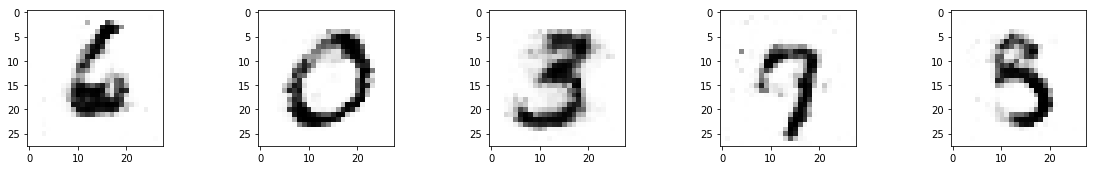

In [8]:
##########################
### VISUALIZATION
##########################


model.eval()
# Make new images
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')